In [11]:
import sys
sys.path.append('/Users/dorisyu/meg_decoding')
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import numpy.ma as ma
import pandas as pd
from time import time
from mne.decoding import SlidingEstimator, cross_val_multiscore, Vectorizer
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler 
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
from matplotlib import pyplot as plt
label_encoder = LabelEncoder()
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score
from scipy.interpolate import interp1d
import mne
from utils import *
from mne.datasets import sample
from mne.preprocessing import ICA

print(__doc__)
data_dir = 'data_meg'
subj = "R2210"
dataqual = 'prepro' #or loc/exp
exp = 'exp' #or exp
dtype = "raw"
label_dir = 'data_log'
save_dir = 'data_meg'
raw_path = f'/Users/dorisyu/meg_decoding/{data_dir}/{subj}/{dataqual}/{subj}_raw_ica.fif'
bad_channels_dict = {
    "R2210": ['MEG 015', 'MEG 014', 'MEG 068', 'MEG 079', 'MEG 147', 'MEG 146', 'MEG 004']
}
bad_channels = bad_channels_dict.get(subj, [])


Automatically created module for IPython interactive environment


In [12]:
raw = mne.io.read_raw_fif(raw_path).load_data()
reject = dict(mag=5e-12, grad=4000e-13)
raw.info['bads'].extend(bad_channels)
sfreq = raw.info['sfreq']
raw.filter(1, 30, method='iir')
downsample = 10
raw.resample(sfreq / downsample)
# raw_empty_room = mne.io.read_raw_fif(f'{data_dir}/{subj}/emptyroom/{subj}_emptyroom-{dtype}.fif', preload=True)
# raw_empty_room.info['bads'].extend(bad_channels)

Opening raw data file /Users/dorisyu/meg_decoding/data_meg/R2210/prepro/R2210_raw_ica.fif...


/var/folders/79/m99pb_8d67l3d79st4zhf4tc0000gn/T/ipykernel_16164/4098733999.py:1: RuntimeWarning: This filename (/Users/dorisyu/meg_decoding/data_meg/R2210/prepro/R2210_raw_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(raw_path).load_data()


    Range : 0 ... 2779999 =      0.000 ...  2779.999 secs
Ready.
Opening raw data file /Users/dorisyu/meg_decoding/data_meg/R2210/prepro/R2210_raw_ica-1.fif...
    Range : 2780000 ... 2954999 =   2780.000 ...  2954.999 secs
Ready.
Reading 0 ... 2954999  =      0.000 ...  2954.999 secs...
Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 1 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 30.00 Hz: -6.02, -6.02 dB

5438 events found on stim channel STI 014
Event IDs: [ 1  2  4  8 16]
5438 events found on stim channel STI 014
Event IDs: [ 1  2  4  8 16]


<Raw | R2210_raw_ica.fif, 193 x 295500 (2955.0 s), ~436.9 MB, data loaded>

Effective window size : 20.480 (s)
Plotting power spectral density (dB=True).


/Users/dorisyu/opt/anaconda3/envs/meg/lib/python3.9/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


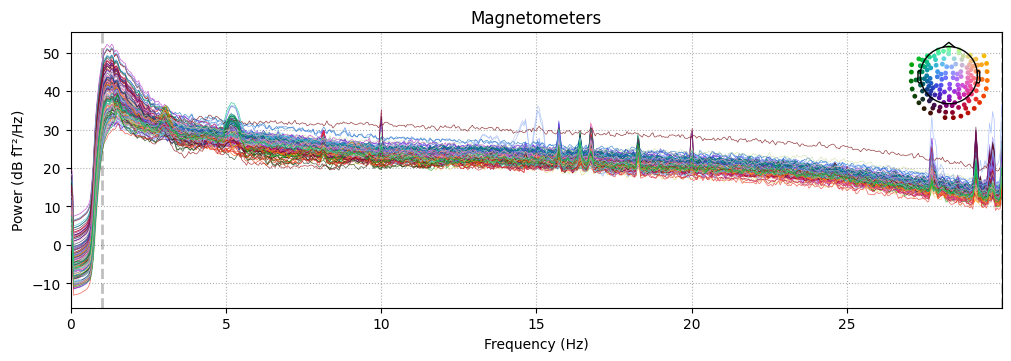

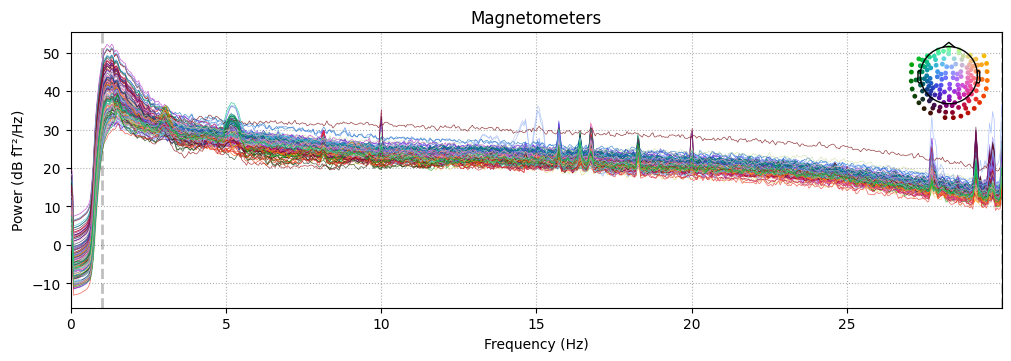

In [13]:
raw.compute_psd(fmax=30).plot(picks="data", exclude="bads", amplitude=False)

In [14]:
events = mne.find_events(raw, stim_channel='STI 014', output='onset', shortest_event=1)
event_id = {
    'start': 1,
    'move': 2,
    'reveal_red': 4,
    'reveal_white': 8,
    'done': 16,
}

# Define trials to remove
start_events = events[events[:, 2] == event_id['start']]
done_events = events[events[:, 2] == event_id['done']]
reveal_red_events = events[events[:, 2] == event_id['reveal_red']]
reveal_white_events = events[events[:, 2] == event_id['reveal_white']]
sfreq = raw.info['sfreq']   # Sampling frequency


5438 events found on stim channel STI 014
Event IDs: [ 1  2  4  8 16]


In [15]:
print(len(start_events))
print(len(reveal_red_events))
print(len(done_events))


120
617
120


In [16]:
# Initialize a list to store trial information
trial_info = []
reveal_red_info = []
previous_start_sample = None
processed_starts = set()
start_idx = 0
done_idx = 0
for idx, start_event in enumerate(start_events):
    start_sample = start_event[0]
    
    # Find the corresponding 'done' event
    while done_idx < len(done_events) and done_events[done_idx, 0] <= start_sample:
        done_idx += 1
    if done_idx < len(done_events):
        done_sample = done_events[done_idx, 0]
        
        # Calculate tmin and tmax for the epoch
        tmin = -0.2  # 0.2 s before 'start'
        tmax = (done_sample - start_sample) / sfreq + 1.0  # Duration from 'start' to 1 s after 'done'
        trial_duration = tmax
        # Find reveal_red and reveal_white events within the trial
        reveal_red_within_trial = reveal_red_events[(reveal_red_events[:, 0] > start_sample) & 
                                                    (reveal_red_events[:, 0] < done_sample)]
        reveal_white_within_trial = reveal_white_events[(reveal_white_events[:, 0] > start_sample) & 
                                                        (reveal_white_events[:, 0] < done_sample)]
        
    # Check if the current start is at least 20 seconds after the previous start
    if previous_start_sample is None or start_sample not in processed_starts:
        # Proceed with processing this start event
        previous_start_sample = start_sample
        processed_starts.add(start_sample)  # Add to the set of processed starts

        # Extract reveal_red events within the trial
        reveal_red_within_trial = reveal_red_events[
            (reveal_red_events[:, 0] > start_sample) & (reveal_red_events[:, 0] < done_sample)
        ]
        reveal_red_info.append({
            'trial_index': start_idx,
            'sequence_index': 0,
            'event_sample': start_sample,
            'time_from_start': 0.0,  # Start of the trial
            'label': 'start'
        })
        reveal_red_info.append({
            'trial_index': start_idx,
            'sequence_index': -1,
            'event_sample': done_sample,
            'time_from_start': (done_sample - start_sample) / sfreq,
            'label': 'end'
        })
        # Add sequential indices to each reveal_red event
        for seq_idx, reveal_red in enumerate(reveal_red_within_trial, start=1):
            reveal_red_info.append({
                'trial_index': start_idx,
                'sequence_index': seq_idx,
                'event_sample': reveal_red[0],
                'time_from_start': (reveal_red[0] - start_sample) / sfreq,
                'label': 'red',  # Label corresponding to the reveal_red event
            })

        # Extract reveal_white events within the trial
        reveal_white_within_trial = reveal_white_events[
            (reveal_white_events[:, 0] > start_sample) & (reveal_white_events[:, 0] < done_sample)
        ]

        # Store trial information
        trial_info.append({
            'event_sample': start_sample,
            'trial_index': start_idx,
            'duration': trial_duration,
            'tmin': -0.2,
            'tmax': trial_duration,
            'done': len(done_events) > 0,
            'start_times': start_sample / sfreq,
            'done_times': done_sample / sfreq,
            'reveal_red': len(reveal_red_within_trial) > 0,  # Boolean flag indicating if 'reveal_red' occurred
            'reveal_red_times': (reveal_red_within_trial[:, 0] - start_sample) / sfreq if len(reveal_red_within_trial) > 0 else [],
            'reveal_white': len(reveal_white_within_trial) > 0,  # Boolean flag indicating if 'reveal_white' occurred
            'reveal_white_times': (reveal_white_within_trial[:, 0] - start_sample) / sfreq if len(reveal_white_within_trial) > 0 else [],
            'reveal_times': sorted(
                ((reveal_red_within_trial[:, 0] - start_sample) / sfreq).tolist() +
                ((reveal_white_within_trial[:, 0] - start_sample) / sfreq).tolist()
            )
        })
        start_idx += 1

trial_info_df = pd.DataFrame(trial_info)
reveal_red_info_df = pd.DataFrame(reveal_red_info)

# # Display results
# print(trial_info_df.head())
print(reveal_red_info_df.tail())


     trial_index  sequence_index  event_sample  time_from_start  label
852          119               0        293503             0.00  start
853          119              -1        294248             7.45    end
854          119               1        293739             2.36    red
855          119               2        293901             3.98    red
856          119               3        294246             7.43    red


In [17]:
# Ensure epoch extraction uses the correct Raw data attributes
n_times = raw.n_times  # Total number of time points in the Raw data
sfreq = raw.info['sfreq']  # Sampling frequency
tmin = -0.5
tmax = 0.5
# Extract response-locked epochs
epochs_data = []
response_locked_info = []

for idx, event in reveal_red_info_df.iterrows():
    reveal_sample = event['event_sample']
    
    # Define start and end samples for the epoch
    start_sample = int(reveal_sample + tmin * sfreq)
    end_sample = int(reveal_sample + tmax * sfreq)
    
    # Ensure the epoch is within valid bounds
    if start_sample >= 0 and end_sample < n_times:
        picks = mne.pick_types(raw.info, meg=True, eeg=False, stim=False, exclude='bads')
        # Extract the epoch data (channels x time points)
        epoch_data, _ = raw[picks, start_sample:end_sample]
        
        # Append the epoch data and metadata
        epochs_data.append(epoch_data)
        response_locked_info.append({
            'trial_index': event['trial_index'],
            'sequence_index': event['sequence_index'],
            'event_sample': reveal_sample,
            'epoch_start': start_sample,
            'epoch_end': end_sample,
            'time_from_start': event['time_from_start'],
            'label': event['label']
        })

# Convert epoch data to a 3D NumPy array
epochs_array = np.stack(epochs_data)  # Shape: (n_epochs, n_channels, n_time_points)

# Convert metadata to a DataFrame
response_locked_df = pd.DataFrame(response_locked_info)

# Display results
print("Response-Locked Epochs Shape:", epochs_array.shape)
print("Response-Locked Metadata:")
print(response_locked_df.tail())


Response-Locked Epochs Shape: (857, 150, 100)
Response-Locked Metadata:
     trial_index  sequence_index  event_sample  epoch_start  epoch_end  \
852          119               0        293503       293453     293553   
853          119              -1        294248       294198     294298   
854          119               1        293739       293689     293789   
855          119               2        293901       293851     293951   
856          119               3        294246       294196     294296   

     time_from_start  label  
852             0.00  start  
853             7.45    end  
854             2.36    red  
855             3.98    red  
856             7.43    red  


In [19]:
global_labels_path = f'/Users/dorisyu/meg_decoding/{label_dir}/{subj}/label.csv'
labels_df = pd.read_csv(global_labels_path)
# Step 1: Get the valid trial indices
valid_trial_indices = {info['trial_index'] for info in trial_info}

# Step 2: Filter labels_df to only include valid trial indices
labels_df_filtered = labels_df[labels_df['trial_index'].isin(valid_trial_indices)]

# Create a mapping from trial_index to label using the filtered  labels_df
label_dict = dict(zip(labels_df_filtered['trial_index'], labels_df_filtered['trial.rule']))

# Step 3: Extract labels for the valid trials in trial_info_valid
y_labels = []
for info in trial_info:
    idx = info['trial_index']
    if idx in label_dict:
        y_labels.append(label_dict[idx])

y_labels = label_encoder.fit_transform(y_labels)

response_locked_df['trial_label'] = response_locked_df['trial_index'].map(label_dict)


In [20]:
# Initialize a dictionary to save cross-validation scores for all sequences
sequence_scores = {}

# Step through each sequence index
for seq_idx in range(-1,5):  # Assuming sequence_index ranges from 0 to 5
    print(f"Training Decoder for Sequence Index {seq_idx}")
    
    # Filter data for the current sequence_index
    idx_filter = response_locked_df['sequence_index'] == seq_idx
    X_train = epochs_array[idx_filter.values]
    y_train = response_locked_df.loc[idx_filter, 'trial_label'].values
    
    if len(np.unique(y_train)) > 1:  # Ensure at least two classes for classification
        # Cross-validation
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        clf = make_pipeline(StandardScaler(), LogisticRegressionCV(max_iter=1000))
        time_decoding = SlidingEstimator(clf, n_jobs=5, scoring='accuracy')
        
        # Train decoder using cross-validation
        split_scores = []  # Store accuracy for each split
        for train_idx, test_idx in cv.split(X_train, y_train):
            X_cv_train, X_cv_test = X_train[train_idx], X_train[test_idx]
            y_cv_train, y_cv_test = y_train[train_idx], y_train[test_idx]
            
            # Fit SlidingEstimator
            time_decoding.fit(X_cv_train, y_cv_train)
            
            # Predict on test set
            y_pred = time_decoding.predict(X_cv_test)  # Shape: (n_samples, n_time_points)
            
            # Compute accuracy for each time point
            time_point_accuracies = [
                accuracy_score(y_cv_test, y_pred[:, t]) for t in range(y_pred.shape[1])
            ]
            split_scores.append(time_point_accuracies)
        
        # Save the scores (shape: 5 splits x 100 time points)
        sequence_scores[seq_idx] = np.array(split_scores)
        print(f"Saved cross-validation scores for Sequence Index {seq_idx}. Shape: {sequence_scores[seq_idx].shape}")
    else:
        print(f"Skipping Sequence Index {seq_idx} (only one class present)")


output_dir = f"output/{subj}"
os.makedirs(output_dir, exist_ok=True)

# Open the file in write-binary mode to overwrite if it exists
with open(f"{output_dir}/sequence_scoresCV_{subj}.npy", "wb") as f:
    np.save(f, sequence_scores)

print(f"Cross-validation scores saved to 'sequence_scoresCV_{subj}.npy'.")



/Users/dorisyu/opt/anaconda3/envs/meg/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Training Decoder for Sequence Index -1


100%|██████████| Fitting SlidingEstimator : 100/100 [00:11<00:00,    8.77it/s]
100%|██████████| Transforming SlidingEstimator : 100/100 [00:00<00:00,  679.49it/s]
100%|██████████| Fitting SlidingEstimator : 100/100 [00:06<00:00,   14.89it/s]
100%|██████████| Transforming SlidingEstimator : 100/100 [00:00<00:00,  656.54it/s]
100%|██████████| Fitting SlidingEstimator : 100/100 [00:06<00:00,   14.53it/s]
100%|██████████| Transforming SlidingEstimator : 100/100 [00:00<00:00,  656.93it/s]
100%|██████████| Fitting SlidingEstimator : 100/100 [00:06<00:00,   15.20it/s]
100%|██████████| Transforming SlidingEstimator : 100/100 [00:00<00:00,  687.39it/s]
100%|██████████| Fitting SlidingEstimator : 100/100 [00:07<00:00,   14.04it/s]
100%|██████████| Transforming SlidingEstimator : 100/100 [00:00<00:00,  604.40it/s]


Saved cross-validation scores for Sequence Index -1. Shape: (5, 100)
Training Decoder for Sequence Index 0


100%|██████████| Fitting SlidingEstimator : 100/100 [00:07<00:00,   14.14it/s]
100%|██████████| Transforming SlidingEstimator : 100/100 [00:00<00:00,  592.77it/s]
100%|██████████| Fitting SlidingEstimator : 100/100 [00:07<00:00,   13.89it/s]
100%|██████████| Transforming SlidingEstimator : 100/100 [00:00<00:00,  576.88it/s]
100%|██████████| Fitting SlidingEstimator : 100/100 [00:07<00:00,   13.94it/s]
100%|██████████| Transforming SlidingEstimator : 100/100 [00:00<00:00,  592.68it/s]
100%|██████████| Fitting SlidingEstimator : 100/100 [00:07<00:00,   13.54it/s]
100%|██████████| Transforming SlidingEstimator : 100/100 [00:00<00:00,  548.06it/s]
100%|██████████| Fitting SlidingEstimator : 100/100 [00:07<00:00,   13.59it/s]
100%|██████████| Transforming SlidingEstimator : 100/100 [00:00<00:00,  630.82it/s]


Saved cross-validation scores for Sequence Index 0. Shape: (5, 100)
Training Decoder for Sequence Index 1


100%|██████████| Fitting SlidingEstimator : 100/100 [00:07<00:00,   13.89it/s]
100%|██████████| Transforming SlidingEstimator : 100/100 [00:00<00:00,  631.39it/s]
100%|██████████| Fitting SlidingEstimator : 100/100 [00:07<00:00,   14.21it/s]
100%|██████████| Transforming SlidingEstimator : 100/100 [00:00<00:00,  702.25it/s]
100%|██████████| Fitting SlidingEstimator : 100/100 [00:06<00:00,   14.72it/s]
100%|██████████| Transforming SlidingEstimator : 100/100 [00:00<00:00,  665.29it/s]
100%|██████████| Fitting SlidingEstimator : 100/100 [00:06<00:00,   14.84it/s]
100%|██████████| Transforming SlidingEstimator : 100/100 [00:00<00:00,  544.03it/s]
100%|██████████| Fitting SlidingEstimator : 100/100 [00:06<00:00,   14.90it/s]
100%|██████████| Transforming SlidingEstimator : 100/100 [00:00<00:00,  651.26it/s]


Saved cross-validation scores for Sequence Index 1. Shape: (5, 100)
Training Decoder for Sequence Index 2


100%|██████████| Fitting SlidingEstimator : 100/100 [00:06<00:00,   14.69it/s]
100%|██████████| Transforming SlidingEstimator : 100/100 [00:00<00:00,  133.75it/s]
100%|██████████| Fitting SlidingEstimator : 100/100 [00:06<00:00,   15.67it/s]
100%|██████████| Transforming SlidingEstimator : 100/100 [00:00<00:00,  551.58it/s]
100%|██████████| Fitting SlidingEstimator : 100/100 [00:08<00:00,   12.29it/s]
100%|██████████| Transforming SlidingEstimator : 100/100 [00:00<00:00,  550.06it/s]
100%|██████████| Fitting SlidingEstimator : 100/100 [00:08<00:00,   11.24it/s]
100%|██████████| Transforming SlidingEstimator : 100/100 [00:00<00:00,  606.73it/s]
100%|██████████| Fitting SlidingEstimator : 100/100 [00:08<00:00,   12.24it/s]
100%|██████████| Transforming SlidingEstimator : 100/100 [00:00<00:00,  582.20it/s]


Saved cross-validation scores for Sequence Index 2. Shape: (5, 100)
Training Decoder for Sequence Index 3


100%|██████████| Fitting SlidingEstimator : 100/100 [00:07<00:00,   12.80it/s]
100%|██████████| Transforming SlidingEstimator : 100/100 [00:00<00:00,  687.57it/s]
100%|██████████| Fitting SlidingEstimator : 100/100 [00:06<00:00,   15.84it/s]
100%|██████████| Transforming SlidingEstimator : 100/100 [00:00<00:00,  626.59it/s]
100%|██████████| Fitting SlidingEstimator : 100/100 [00:06<00:00,   15.26it/s]
100%|██████████| Transforming SlidingEstimator : 100/100 [00:00<00:00,  572.94it/s]
100%|██████████| Fitting SlidingEstimator : 100/100 [00:06<00:00,   15.38it/s]
100%|██████████| Transforming SlidingEstimator : 100/100 [00:00<00:00,  636.14it/s]
100%|██████████| Fitting SlidingEstimator : 100/100 [00:06<00:00,   15.03it/s]
100%|██████████| Transforming SlidingEstimator : 100/100 [00:00<00:00,  557.91it/s]


Saved cross-validation scores for Sequence Index 3. Shape: (5, 100)
Training Decoder for Sequence Index 4


100%|██████████| Fitting SlidingEstimator : 100/100 [00:06<00:00,   16.37it/s]
100%|██████████| Transforming SlidingEstimator : 100/100 [00:00<00:00,  666.40it/s]
100%|██████████| Fitting SlidingEstimator : 100/100 [00:06<00:00,   16.07it/s]
100%|██████████| Transforming SlidingEstimator : 100/100 [00:00<00:00,  640.41it/s]
100%|██████████| Fitting SlidingEstimator : 100/100 [00:06<00:00,   15.75it/s]
100%|██████████| Transforming SlidingEstimator : 100/100 [00:00<00:00,  624.51it/s]
100%|██████████| Fitting SlidingEstimator : 100/100 [00:06<00:00,   16.47it/s]
100%|██████████| Transforming SlidingEstimator : 100/100 [00:00<00:00,  592.47it/s]
100%|██████████| Fitting SlidingEstimator : 100/100 [00:05<00:00,   16.89it/s]
100%|██████████| Transforming SlidingEstimator : 100/100 [00:00<00:00,  614.35it/s]


Saved cross-validation scores for Sequence Index 4. Shape: (5, 100)
Cross-validation scores saved to 'sequence_scoresCV_R2210.npy'.


In [21]:
# Initialize a dictionary to save cross-validation scores for all sequences
sequence_scores = {}

# Step through each sequence index
for seq_idx in range(-1,5):  # Assuming sequence_index ranges from 0 to 5
    print(f"Training Decoder for Sequence Index {seq_idx}")

    # Filter data for the current sequence_index
    train_filter = response_locked_df['sequence_index'] == seq_idx
    X_train = epochs_array[train_filter.values]
    y_train = response_locked_df.loc[train_filter, 'trial_label'].values
    
    # Use data from other sequences as the test set
    test_filter = response_locked_df['sequence_index'] != seq_idx
    X_test = epochs_array[test_filter.values]
    y_test = response_locked_df.loc[test_filter, 'trial_label'].values
    
    if len(np.unique(y_train)) > 1 and len(np.unique(y_test)) > 1:  # Ensure at least two classes for classification
        clf = make_pipeline(StandardScaler(), LogisticRegressionCV(max_iter=1000))
        time_decoding = SlidingEstimator(clf, n_jobs=5, scoring='accuracy')
        
        # Train decoder on the current sequence
        time_decoding.fit(X_train, y_train)
        
        # Predict on the test set (other sequences)
        y_pred = time_decoding.predict(X_test)  # Shape: (n_samples, n_time_points)
        
        # Compute accuracy for each time point
        time_point_accuracies = [
            accuracy_score(y_test, y_pred[:, t]) for t in range(y_pred.shape[1])
        ]
        
        # Save the scores
        sequence_scores[seq_idx] = np.array(time_point_accuracies)
        mean_acc = np.mean(time_point_accuracies)
        print(f"Mean accuracy for Sequence Index {seq_idx}: {mean_acc}")
        print(f"Saved cross-validation scores for Sequence Index {seq_idx}. Shape: {sequence_scores[seq_idx].shape}")
    else:
        print(f"Skipping Sequence Index {seq_idx} (only one class present in train or test set)")
    
output_dir = f"output/{subj}"
os.makedirs(output_dir, exist_ok=True)

# Open the file in write-binary mode to overwrite if it exists
with open(f"{output_dir}/train_test_CV_{subj}.npy", "wb") as f:
    np.save(f, sequence_scores)


Training Decoder for Sequence Index -1


100%|██████████| Fitting SlidingEstimator : 100/100 [00:09<00:00,   10.35it/s]
100%|██████████| Transforming SlidingEstimator : 100/100 [00:00<00:00,  148.52it/s]


Mean accuracy for Sequence Index -1: 0.35816824966078703
Saved cross-validation scores for Sequence Index -1. Shape: (100,)
Training Decoder for Sequence Index 0


100%|██████████| Fitting SlidingEstimator : 100/100 [00:09<00:00,   10.96it/s]
100%|██████████| Transforming SlidingEstimator : 100/100 [00:00<00:00,  182.73it/s]


Mean accuracy for Sequence Index 0: 0.3446811397557666
Saved cross-validation scores for Sequence Index 0. Shape: (100,)
Training Decoder for Sequence Index 1


100%|██████████| Fitting SlidingEstimator : 100/100 [00:08<00:00,   11.15it/s]
100%|██████████| Transforming SlidingEstimator : 100/100 [00:00<00:00,  182.10it/s]


Mean accuracy for Sequence Index 1: 0.34557666214382626
Saved cross-validation scores for Sequence Index 1. Shape: (100,)
Training Decoder for Sequence Index 2


100%|██████████| Fitting SlidingEstimator : 100/100 [00:08<00:00,   12.04it/s]
100%|██████████| Transforming SlidingEstimator : 100/100 [00:00<00:00,  162.47it/s]


Mean accuracy for Sequence Index 2: 0.34408412483039347
Saved cross-validation scores for Sequence Index 2. Shape: (100,)
Training Decoder for Sequence Index 3


100%|██████████| Fitting SlidingEstimator : 100/100 [00:07<00:00,   13.32it/s]
100%|██████████| Transforming SlidingEstimator : 100/100 [00:00<00:00,  178.06it/s]


Mean accuracy for Sequence Index 3: 0.38442536327608984
Saved cross-validation scores for Sequence Index 3. Shape: (100,)
Training Decoder for Sequence Index 4


100%|██████████| Fitting SlidingEstimator : 100/100 [00:06<00:00,   14.33it/s]
100%|██████████| Transforming SlidingEstimator : 100/100 [00:00<00:00,  155.32it/s]


Mean accuracy for Sequence Index 4: 0.3649167733674776
Saved cross-validation scores for Sequence Index 4. Shape: (100,)


In [22]:
# Initialize a dictionary to save cross-validation scores for all sequences
sequence_scores = {}

# Step through each sequence index
for seq_idx in range(-1,5):  # Assuming sequence_index ranges from 0 to 5
    print(f"Training Decoder for Sequence Index {seq_idx}")

    test_filter = response_locked_df['sequence_index'] == seq_idx
    train_filter = response_locked_df['sequence_index'] != seq_idx
    X_train = epochs_array[train_filter.values]
    y_train = response_locked_df.loc[train_filter, 'trial_label'].values
    X_test = epochs_array[test_filter.values]
    y_test = response_locked_df.loc[test_filter, 'trial_label'].values
    
    if len(np.unique(y_train)) > 1 and len(np.unique(y_test)) > 1:  # Ensure at least two classes for classification
        clf = make_pipeline(StandardScaler(), LogisticRegressionCV(max_iter=1000))
        time_decoding = SlidingEstimator(clf, n_jobs=5, scoring='accuracy')
        
        # Train decoder on the current sequence
        time_decoding.fit(X_train, y_train)
        
        # Predict on the test set (other sequences)
        y_pred = time_decoding.predict(X_test)  # Shape: (n_samples, n_time_points)
        
        # Compute accuracy for each time point
        time_point_accuracies = [
            accuracy_score(y_test, y_pred[:, t]) for t in range(y_pred.shape[1])
        ]
        
        # Save the scores
        sequence_scores[seq_idx] = np.array(time_point_accuracies)
        mean_acc = np.mean(time_point_accuracies)
        print(f"Mean accuracy for Sequence Index {seq_idx}: {mean_acc}")
        print(f"Saved cross-validation scores for Sequence Index {seq_idx}. Shape: {sequence_scores[seq_idx].shape}")
    else:
        print(f"Skipping Sequence Index {seq_idx} (only one class present in train or test set)")
    
output_dir = f"output/{subj}"
os.makedirs(output_dir, exist_ok=True)

# Open the file in write-binary mode to overwrite if it exists
with open(f"{output_dir}/test_train_CV_{subj}.npy", "wb") as f:
    np.save(f, sequence_scores)


Training Decoder for Sequence Index -1


 17%|█▋        | Fitting SlidingEstimator : 17/100 [00:25<01:54,    1.38s/it]/Users/dorisyu/opt/anaconda3/envs/meg/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 30%|███       | Fitting SlidingEstimator : 30/100 [00:47<01:49,    1.56s/it]/Users/dorisyu/opt/anaconda3/envs/meg/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.

Mean accuracy for Sequence Index -1: 0.34375000000000006
Saved cross-validation scores for Sequence Index -1. Shape: (100,)
Training Decoder for Sequence Index 0


  9%|▉         | Fitting SlidingEstimator : 9/100 [00:16<02:44,    1.81s/it]/Users/dorisyu/opt/anaconda3/envs/meg/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 42%|████▏     | Fitting SlidingEstimator : 42/100 [01:03<01:24,    1.46s/it]/Users/dorisyu/opt/anaconda3/envs/meg/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.o

Mean accuracy for Sequence Index 0: 0.3311666666666667
Saved cross-validation scores for Sequence Index 0. Shape: (100,)
Training Decoder for Sequence Index 1


 14%|█▍        | Fitting SlidingEstimator : 14/100 [00:22<02:11,    1.53s/it]/Users/dorisyu/opt/anaconda3/envs/meg/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 27%|██▋       | Fitting SlidingEstimator : 27/100 [00:40<01:42,    1.41s/it]/Users/dorisyu/opt/anaconda3/envs/meg/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.

Mean accuracy for Sequence Index 1: 0.32675000000000004
Saved cross-validation scores for Sequence Index 1. Shape: (100,)
Training Decoder for Sequence Index 2


  8%|▊         | Fitting SlidingEstimator : 8/100 [00:12<02:19,    1.51s/it]/Users/dorisyu/opt/anaconda3/envs/meg/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 18%|█▊        | Fitting SlidingEstimator : 18/100 [00:27<01:57,    1.43s/it]/Users/dorisyu/opt/anaconda3/envs/meg/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.o

Mean accuracy for Sequence Index 2: 0.3319166666666667
Saved cross-validation scores for Sequence Index 2. Shape: (100,)
Training Decoder for Sequence Index 3


 16%|█▌        | Fitting SlidingEstimator : 16/100 [00:26<02:17,    1.63s/it]/Users/dorisyu/opt/anaconda3/envs/meg/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 56%|█████▌    | Fitting SlidingEstimator : 56/100 [01:21<01:00,    1.37s/it]/Users/dorisyu/opt/anaconda3/envs/meg/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.

Mean accuracy for Sequence Index 3: 0.37250000000000005
Saved cross-validation scores for Sequence Index 3. Shape: (100,)
Training Decoder for Sequence Index 4


 12%|█▏        | Fitting SlidingEstimator : 12/100 [00:19<02:16,    1.55s/it]/Users/dorisyu/opt/anaconda3/envs/meg/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 15%|█▌        | Fitting SlidingEstimator : 15/100 [00:24<02:14,    1.58s/it]/Users/dorisyu/opt/anaconda3/envs/meg/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.

Mean accuracy for Sequence Index 4: 0.3864473684210526
Saved cross-validation scores for Sequence Index 4. Shape: (100,)


In [34]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

subj = ["R2210"]
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']  # Colors for each sequence index

def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

plt.figure(figsize=(12, 7))

accumulated_scores = {seq_idx: [] for seq_idx in range(6)}  # Assuming 6 sequence indices
accumulated_scores[-1] = []

for sub in subj:
    sub = 'R2210'
    sequence_scores = np.load(f"output/{sub}/TestOnSeq_train_CV_{sub}.npy", allow_pickle=True).item()
    print(sequence_scores.keys())
    # Accumulate scores for each sequence index
    for seq_idx, scores in sequence_scores.items():
        accumulated_scores[seq_idx].append(scores)
print(accumulated_scores)


dict_keys([-1, 0, 1, 2, 3, 4])
{0: [array([0.33333333, 0.4       , 0.33333333, 0.33333333, 0.36666667,
       0.325     , 0.325     , 0.325     , 0.325     , 0.325     ,
       0.31666667, 0.325     , 0.325     , 0.325     , 0.30833333,
       0.325     , 0.31666667, 0.35      , 0.35      , 0.36666667,
       0.34166667, 0.30833333, 0.3       , 0.34166667, 0.35833333,
       0.33333333, 0.325     , 0.325     , 0.33333333, 0.28333333,
       0.3       , 0.275     , 0.325     , 0.325     , 0.30833333,
       0.29166667, 0.33333333, 0.325     , 0.33333333, 0.325     ,
       0.325     , 0.325     , 0.325     , 0.325     , 0.33333333,
       0.31666667, 0.225     , 0.325     , 0.325     , 0.30833333,
       0.31666667, 0.325     , 0.35      , 0.31666667, 0.33333333,
       0.35      , 0.33333333, 0.36666667, 0.36666667, 0.325     ,
       0.34166667, 0.35833333, 0.4       , 0.38333333, 0.375     ,
       0.31666667, 0.34166667, 0.325     , 0.325     , 0.325     ,
       0.35      , 0.33333